# Volatility Forecasting

_This setup code is required to run in an IPython notebook_

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

## Data
These examples make use of S&P 500 data from Yahoo! that is available from `arch.data.sp500`.

In [2]:
import sys

import numpy as np
import pandas as pd

import arch.data.sp500
from arch import arch_model

data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

## Basic Forecasting
Forecasts can be generated for standard GARCH(p,q) processes using any of the three forecast generation methods:

* Analytical
* Simulation-based
* Bootstrap-based

Be default forecasts will only be produced for the final observation in the sample so that they are out-of-sample.

Forecasts start with specifying the model and estimating parameters.

In [3]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(update_freq=5)

Iteration:      5,   Func. Count:     35,   Neg. LLF: 6970.2765831170655
Iteration:     10,   Func. Count:     63,   Neg. LLF: 6936.718477482658
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6936.718476988985
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 11


In [4]:
forecasts = res.forecast()

Forecasts are contained in an `ARCHModelForecast` object which has 4 attributes:

* `mean` - The forecast means
* `residual_variance` - The forecast residual variances, that is $E_t[\epsilon_{t+h}^2]$
* `variance` - The forecast variance of the process, $E_t[r_{t+h}^2]$.  The variance will differ from the residual variance whenever the model has mean dynamics, e.g., in an AR process.
* `simulations` - An object that contains detailed information about the simulations used to generate forecasts.  Only used if the forecast `method` is set to `'simulation'` or `'bootstrap'`.  If using `'analytical'` (the default), this is `None`.

The three main outputs are all returned in `DataFrame`s with columns of the form `h.#` where `#` is the number of steps ahead.  That is, `h.1` corresponds to one-step ahead forecasts while `h.10` corresponds to 10-steps ahead.

The default forecast only produces 1-step ahead forecasts.

In [5]:
print(forecasts.mean.iloc[-3:])
print(forecasts.residual_variance.iloc[-3:])
print(forecasts.variance.iloc[-3:])

                 h.1
Date                
2018-12-31  0.056353
                h.1
Date               
2018-12-31  3.59647
                h.1
Date               
2018-12-31  3.59647


Longer horizon forecasts can be computed by passing the parameter `horizon`.

In [6]:
forecasts = res.forecast(horizon=5)
print(forecasts.residual_variance.iloc[-3:])

                h.1       h.2       h.3       h.4       h.5
Date                                                       
2018-12-31  3.59647  3.568502  3.540887  3.513621  3.486701


## Alternative Forecast Generation Schemes

### Fixed Window Forecasting

Fixed-windows forecasting uses data up to a specified date to generate all forecasts after that date. This can be implemented by passing the entire data in when initializing the model and then using ``last_obs`` when calling ``fit``.  ``forecast()`` will, by default, produce forecasts after this final date.

**Note** ``last_obs`` follow Python sequence rules so that the actual date in ``last_obs`` is not in the sample.

In [7]:
res = am.fit(last_obs="2011-1-1", update_freq=5)
forecasts = res.forecast(horizon=5)
print(forecasts.variance.dropna().head())

Iteration:      5,   Func. Count:     34,   Neg. LLF: 4578.71329752255
Iteration:     10,   Func. Count:     63,   Neg. LLF: 4555.33845173251
Optimization terminated successfully    (Exit mode 0)
            Current function value: 4555.285110045305
            Iterations: 14
            Function evaluations: 83
            Gradient evaluations: 14


                 h.1       h.2       h.3       h.4       h.5
Date                                                        
2010-12-31  0.381757  0.390905  0.399988  0.409008  0.417964
2011-01-03  0.451724  0.460381  0.468976  0.477512  0.485987
2011-01-04  0.428416  0.437236  0.445994  0.454691  0.463326
2011-01-05  0.420554  0.429429  0.438242  0.446993  0.455683
2011-01-06  0.402483  0.411486  0.420425  0.429301  0.438115


### Rolling Window Forecasting

Rolling window forecasts use a fixed sample length and then produce one-step from the final observation.  These can be implemented using ``first_obs`` and ``last_obs``.

In [8]:
index = returns.index
start_loc = 0
end_loc = np.where(index >= "2010-1-1")[0].min()
forecasts = {}
for i in range(20):
    sys.stdout.write(".")
    sys.stdout.flush()
    res = am.fit(first_obs=i, last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


                 h.1       h.2       h.3
2009-12-31  0.615314  0.621743  0.628133
2010-01-04  0.751747  0.757343  0.762905
2010-01-05  0.710453  0.716315  0.722142
2010-01-06  0.666244  0.672346  0.678411
2010-01-07  0.634424  0.640706  0.646949
2010-01-08  0.600109  0.606595  0.613040
2010-01-11  0.565514  0.572212  0.578869
2010-01-12  0.599561  0.606051  0.612501
2010-01-13  0.608309  0.614748  0.621148
2010-01-14  0.575065  0.581756  0.588406
2010-01-15  0.629890  0.636245  0.642561
2010-01-19  0.695074  0.701042  0.706974
2010-01-20  0.737154  0.742908  0.748627
2010-01-21  0.954167  0.958725  0.963255
2010-01-22  1.253453  1.256401  1.259332
2010-01-25  1.178691  1.182043  1.185374
2010-01-26  1.112205  1.115886  1.119545
2010-01-27  1.051295  1.055327  1.059335
2010-01-28  1.085678  1.089512  1.093324
2010-01-29  1.085786  1.089593  1.093378


### Recursive Forecast Generation

Recursive is similar to rolling except that the initial observation does not change.  This can be easily implemented by dropping the ``first_obs`` input.

In [9]:
import numpy as np
import pandas as pd

index = returns.index
start_loc = 0
end_loc = np.where(index >= "2010-1-1")[0].min()
forecasts = {}
for i in range(20):
    sys.stdout.write(".")
    sys.stdout.flush()
    res = am.fit(last_obs=i + end_loc, disp="off")
    temp = res.forecast(horizon=3).variance
    fcast = temp.iloc[0]
    forecasts[fcast.name] = fcast
print()
print(pd.DataFrame(forecasts).T)

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.


                 h.1       h.2       h.3
2009-12-31  0.615314  0.621743  0.628133
2010-01-04  0.751723  0.757321  0.762885
2010-01-05  0.709956  0.715791  0.721591
2010-01-06  0.666057  0.672146  0.678197
2010-01-07  0.634503  0.640776  0.647011
2010-01-08  0.600417  0.606893  0.613329
2010-01-11  0.565684  0.572369  0.579014
2010-01-12  0.599963  0.606438  0.612874
2010-01-13  0.608558  0.614982  0.621366
2010-01-14  0.575020  0.581639  0.588217
2010-01-15  0.629696  0.635989  0.642244
2010-01-19  0.694735  0.700656  0.706541
2010-01-20  0.736509  0.742193  0.747842
2010-01-21  0.952751  0.957245  0.961713
2010-01-22  1.251145  1.254050  1.256936
2010-01-25  1.176864  1.180162  1.183441
2010-01-26  1.110848  1.114497  1.118124
2010-01-27  1.050102  1.054077  1.058028
2010-01-28  1.084669  1.088454  1.092216
2010-01-29  1.085003  1.088783  1.092541


## TARCH

### Analytical Forecasts

All ARCH-type models have one-step analytical forecasts.  Longer horizons only have closed forms for specific models.  TARCH models do not have closed-form (analytical) forecasts for horizons larger than 1, and so simulation or bootstrapping is required.  Attempting to produce forecasts for horizons larger than 1 using `method='analytical'` results in a `ValueError`. 

In [10]:
# TARCH specification
am = arch_model(returns, vol="GARCH", power=2.0, p=1, o=1, q=1)
res = am.fit(update_freq=5)
forecasts = res.forecast()
print(forecasts.variance.iloc[-1])

Iteration:      5,   Func. Count:     40,   Neg. LLF: 6846.496611626368
Iteration:     10,   Func. Count:     75,   Neg. LLF: 6822.883179368218
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6822.882823437632
            Iterations: 13
            Function evaluations: 93
            Gradient evaluations: 13
h.1    3.010188
Name: 2018-12-31 00:00:00, dtype: float64


### Simulation Forecasts

When using simulation- or bootstrap-based forecasts, an additional attribute of an `ARCHModelForecast` object is meaningful -- `simulation`.

(np.float64(16804.0), np.float64(17165.0))

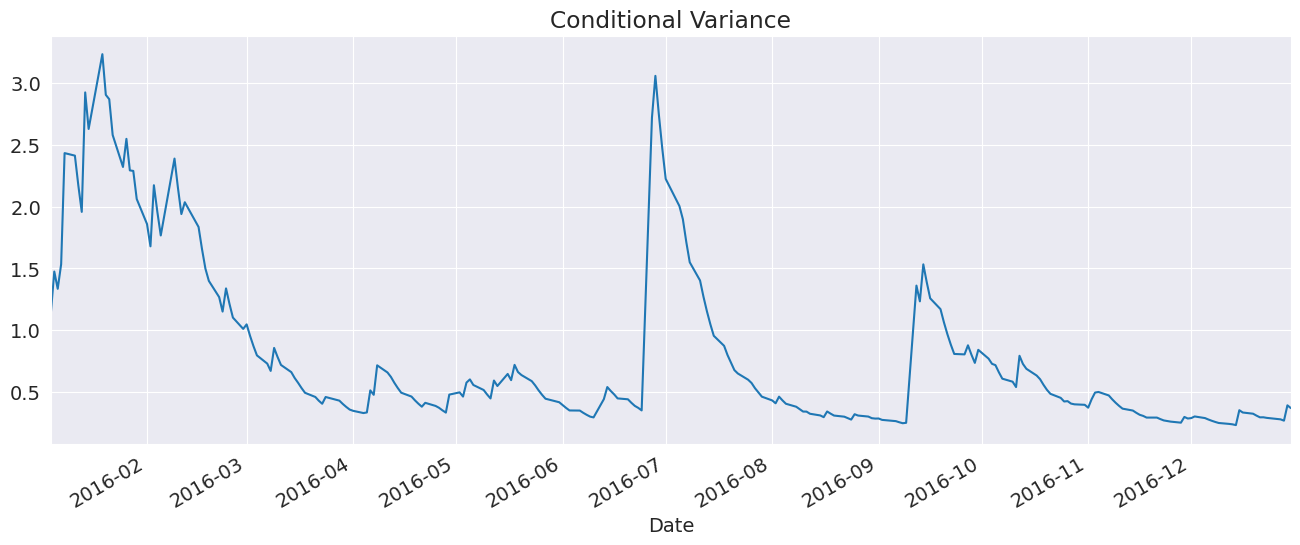

In [11]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
var_2016 = res.conditional_volatility["2016"] ** 2.0
subplot = var_2016.plot(ax=ax, title="Conditional Variance")
subplot.set_xlim(var_2016.index[0], var_2016.index[-1])

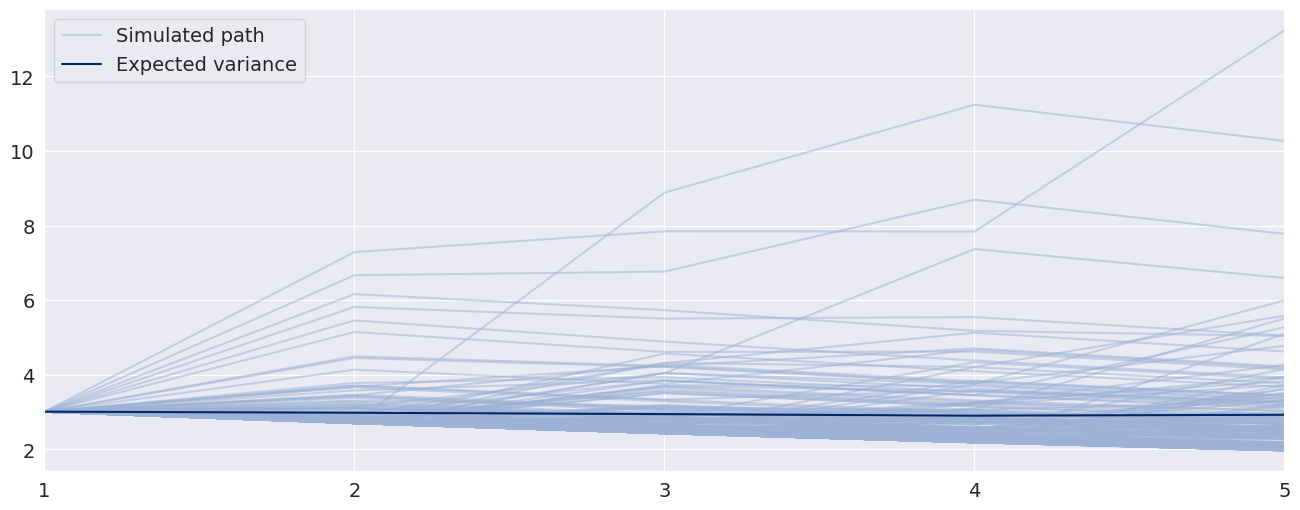

In [12]:
forecasts = res.forecast(horizon=5, method="simulation")
sims = forecasts.simulations

x = np.arange(1, 6)
lines = plt.plot(x, sims.residual_variances[-1, ::5].T, color="#9cb2d6", alpha=0.5)
lines[0].set_label("Simulated path")
line = plt.plot(x, forecasts.variance.iloc[-1].values, color="#002868")
line[0].set_label("Expected variance")
plt.gca().set_xticks(x)
plt.gca().set_xlim(1, 5)
legend = plt.legend()

### Bootstrap Forecasts

Bootstrap-based forecasts are nearly identical to simulation-based forecasts except that the values used to simulate the process are computed from historical data rather than using the assumed distribution of the residuals. Forecasts produced using this method also return an `ARCHModelForecastSimulation` containing information about the simulated paths.

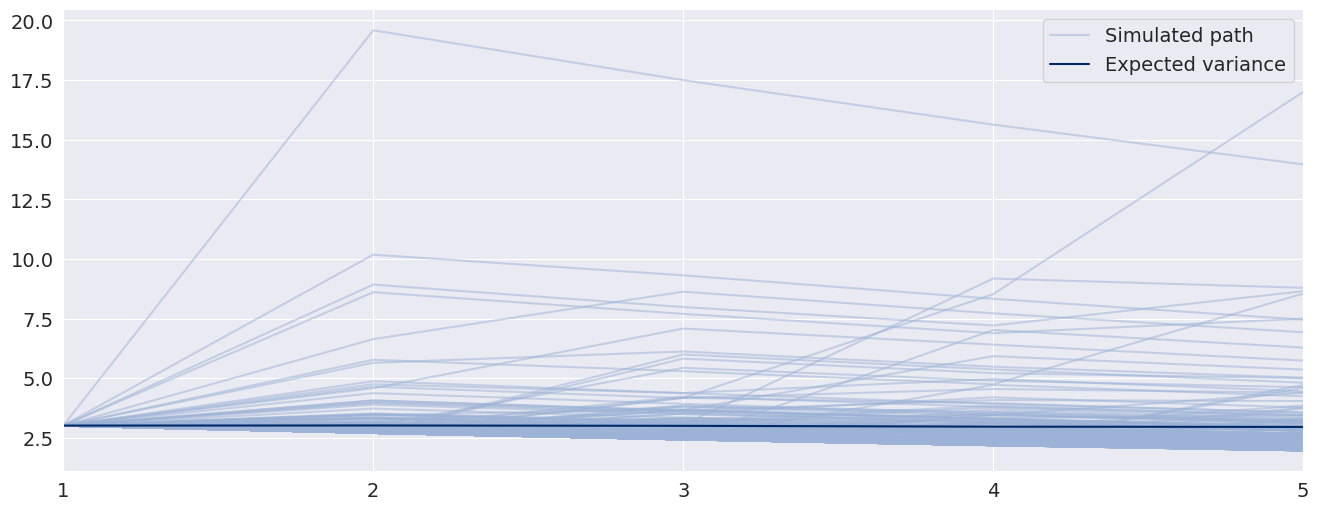

In [13]:
forecasts = res.forecast(horizon=5, method="bootstrap")
sims = forecasts.simulations

lines = plt.plot(x, sims.residual_variances[-1, ::5].T, color="#9cb2d6", alpha=0.5)
lines[0].set_label("Simulated path")
line = plt.plot(x, forecasts.variance.iloc[-1].values, color="#002868")
line[0].set_label("Expected variance")
plt.gca().set_xticks(x)
plt.gca().set_xlim(1, 5)
legend = plt.legend()

# Value-at-Risk Forecasting
Value-at-Risk (VaR) forecasts from GARCH models depend on the conditional mean, the conditional volatility and the quantile of the standardized residuals,

$$VaR_{t+1|t} = -\mu_{t+1|t} - \sigma_{t+1|t} q_{\alpha}$$

where $q_{\alpha}$ is the $\alpha$ quantile of the standardized residuals, e.g., 5%. 

The quantile can be either computed from the estimated model density or computed using the empirical distribution of the standardized residuals.  The example below shows both methods.

In [14]:
am = arch_model(returns, vol="Garch", p=1, o=0, q=1, dist="skewt")
res = am.fit(disp="off", last_obs="2017-12-31")

## Parametric VaR
First, we use the model to estimate the VaR.  The quantiles can be computed using the `ppf` method of the distribution attached to the model. The quantiles are printed below.

**Note**: `forecast` is called with `align="target"` so that the forecasts are already aligned with the target and so do not need further shifting.

In [15]:
forecasts = res.forecast(align="target")
cond_mean = forecasts.mean["2018":].dropna()
cond_var = forecasts.variance["2018":].dropna()
q = am.distribution.ppf([0.01, 0.05], res.params[-2:])
print(q)

[-2.64484999 -1.64965918]


Next, we plot the two VaRs along with the returns.  The returns that violate the VaR forecasts are highlighted. 

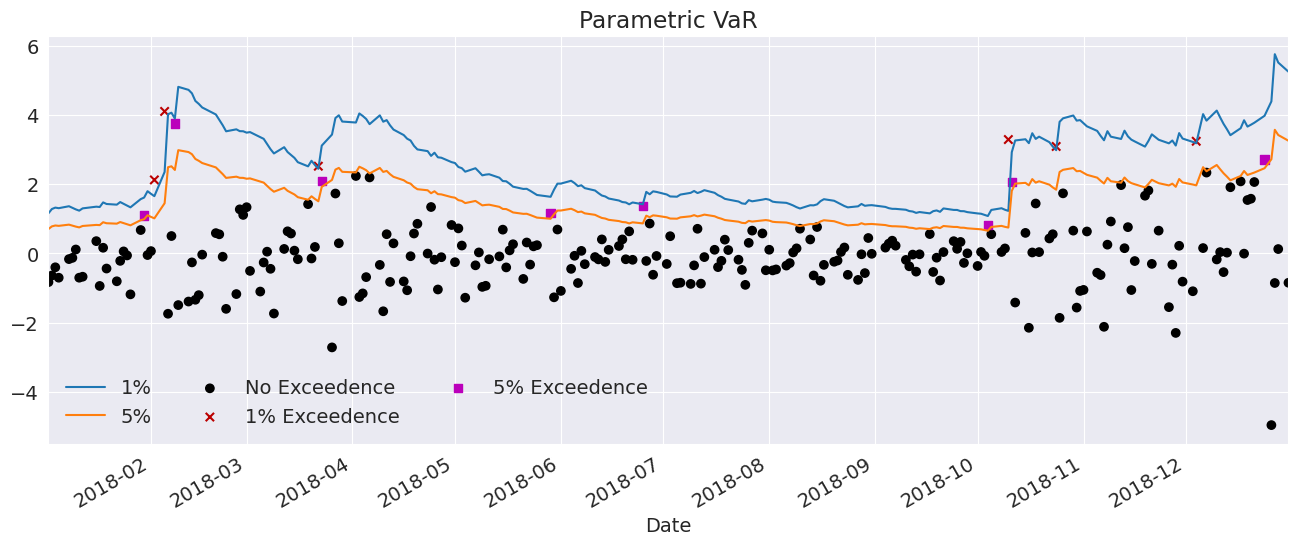

In [16]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns["2018":].copy()
rets_2018.name = "S&P 500 Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
labels = {
    "#BB0000": "1% Exceedence",
    "#BB00BB": "5% Exceedence",
    "#000000": "No Exceedence",
}
markers = {"#BB0000": "x", "#BB00BB": "s", "#000000": "o"}
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Parametric VaR")
leg = ax.legend(frameon=False, ncol=3)

## Filtered Historical Simulation

Next, we use the empirical distribution of the standardized residuals to estimate the quantiles.  These values are very similar to those estimated using the assumed distribution.  The plot below is identical except for the slightly different quantiles.

In [17]:
std_rets = (returns[:"2017"] - res.params["mu"]) / res.conditional_volatility
std_rets = std_rets.dropna()
q = std_rets.quantile([0.01, 0.05])
print(q)

0.01   -2.668273
0.05   -1.723352
dtype: float64


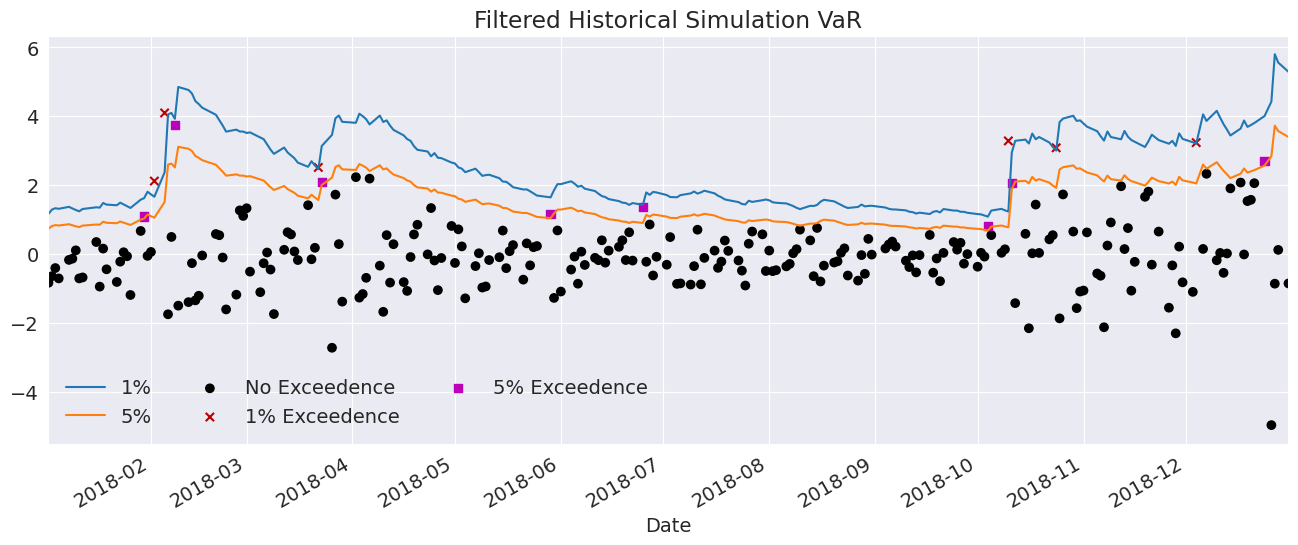

In [18]:
value_at_risk = -cond_mean.values - np.sqrt(cond_var).values * q.values[None, :]
value_at_risk = pd.DataFrame(value_at_risk, columns=["1%", "5%"], index=cond_var.index)
ax = value_at_risk.plot(legend=False)
xl = ax.set_xlim(value_at_risk.index[0], value_at_risk.index[-1])
rets_2018 = returns["2018":].copy()
rets_2018.name = "S&P 500 Return"
c = []
for idx in value_at_risk.index:
    if rets_2018[idx] > -value_at_risk.loc[idx, "5%"]:
        c.append("#000000")
    elif rets_2018[idx] < -value_at_risk.loc[idx, "1%"]:
        c.append("#BB0000")
    else:
        c.append("#BB00BB")
c = np.array(c, dtype="object")
for color in np.unique(c):
    sel = c == color
    ax.scatter(
        rets_2018.index[sel],
        -rets_2018.loc[sel],
        marker=markers[color],
        c=c[sel],
        label=labels[color],
    )
ax.set_title("Filtered Historical Simulation VaR")
leg = ax.legend(frameon=False, ncol=3)